In [0]:
import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os
import pickle
from sklearn.metrics import confusion_matrix

In [0]:
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
class Cifar10CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5,padding=2)
    self.max = nn.MaxPool2d(2,stride = 2)
    self.conv2 = nn.Conv2d(6,12,5,padding=2)
    self.conv3 = nn.Conv2d(12,24,5,padding=2)
    self.fc1 = nn.Linear(384,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)
    self.conv_net = nn.Sequential(self.conv1,nn.ReLU(),self.max,self.conv2,nn.ReLU(),self.max,self.conv3,nn.ReLU(),self.max)
    self.fc_net = nn.Sequential(self.fc1,nn.ReLU(),self.fc2,nn.ReLU(),self.fc3,nn.Softmax())
  def forward(self,x):
    out = self.conv_net(x)
    out = out.view(-1,384)
    out = self.fc_net(out)
    return out
 

In [0]:
class Cifar10Dataset(Dataset):
  def __init__(self,mode = 'train'):
    super().__init__()
    if mode == 'train':
      data_list = []
      label_list = []
      for i in range(5):
        file_path = 'cifar-10-batches-py/data_batch_' + str(i + 1)
        file = self.unpickle(file_path)
        data = file[b'data'].reshape(10000,3,32,32)
        #label = np.eye(10)[file[b'labels']]
        label = np.array(file[b'labels'])
        data_list.append(data)
        label_list.append(label)
        self.data = np.concatenate(data_list,axis = 0)
        self.labels = np.concatenate(label_list,axis = 0)
    else:
      file_path = 'cifar-10-batches-py/test_batch'
      file = self.unpickle(file_path)
      self.data = file[b'data'].reshape(10000,3,32,32)
      #label = np.eye(10)[file[b'labels']]
      self.labels = np.array(file[b'labels'])
    
  def unpickle(self,file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
  def __len__(self):
    return len(self.labels)
  def __getitem__(self,idx):
    data = self.data[idx]
    #normalize the input
    data = (data - 127.5) / 127.5
    label = self.labels[idx]
    return {'data':data,'label':label}

In [0]:
from google.colab import files
file = files.upload()

Saving cifar-10-python.tar.gz to cifar-10-python.tar.gz


In [0]:
trainset = Cifar10Dataset()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True)
#trainset[1]['data'].shape

model = Cifar10CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = .001)
criterion = nn.CrossEntropyLoss()
losses = []
for epoch in range(20):
  for i,data in enumerate(trainloader, 0):
    inputs = data['data'].float().to(device)
    #print(data['label'][2])
    labels = data['label'].long().to(device)
    
        # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    losses.append(loss)
    optimizer.step()


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[[683  12  44  12  22   7  17  13 143  47]
 [ 38 677  15  14  13   3  17   9  84 130]
 [ 91   8 498  55 122  79  83  24  29  11]
 [ 25   6  93 347  74 205 128  41  42  39]
 [ 31   5  90  45 544  73  96  79  30   7]
 [ 11   0  88 129  66 533  57  66  29  21]
 [ 12   5  47  38  71  22 751  14  25  15]
 [ 21   1  46  52  82  98  22 637  10  31]
 [ 73  27  15  15   6   7  10   5 821  21]
 [ 40  97  12  22  10  12  34  25  80 668]]


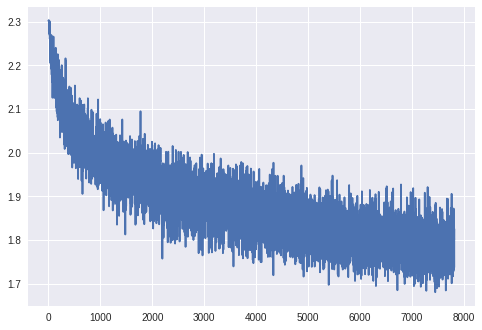

In [0]:
plt.plot(losses)
testset = Cifar10Dataset('test')
testloader = torch.utils.data.DataLoader(testset, batch_size=10000)
for i,data in enumerate(testloader,0):
  test_inputs = data['data'].float().to(device)
  test_outputs = model(test_inputs)
  _,prediction = test_outputs.max(1)
  prediction = prediction.cpu().data.numpy()
  true = data['label'].data.numpy()
  print(confusion_matrix(true,prediction))

In [0]:
class Cifar10LSTMCell(nn.Module):
  def __init__(self,batch_size,hidden_neuron):
    super().__init__()
    self.wf = nn.Linear(2 + hidden_neuron,hidden_neuron)
    self.wi = nn.Linear(2 + hidden_neuron,hidden_neuron)
    self.wc = nn.Linear(2 + hidden_neuron,hidden_neuron)
    self.wo = nn.Linear(2 + hidden_neuron,hidden_neuron)
    #self.hidden,self.c = self.init_hidden()
    self.hidden_to_prediction = nn.Linear(hidden_neuron,2)
    self.hidden_size = hidden_neuron
    self.batch_size = batch_size
  def init_hidden(self):
    return (torch.zeros(self.batch_size, self.hidden_size),torch.zeros(self.batch_size, self.hidden_size))
  def forward(self,inp,hidden,cell):
    concat = torch.cat((inp, hidden), 1)
    f = torch.sigmoid(self.wf(concat))
    i = torch.sigmoid(self.wi(concat))
    c_tilda = torch.tanh(self.wc(concat))
    cell = f * cell+ i * c_tilda
    o = torch.sigmoid(self.wo(concat))
    hidden = o * torch.tanh(cell)
    out = self.hidden_to_prediction(hidden)
    return out,hidden,cell

In [0]:
# Data set create
class LotkaVolterra(Dataset):
  def __init__(self,mode = 'train'):
    super().__init__()
    self.y_init = [10,5]
    self.hyper_parameters = (1,.1,1.5,.75)
    self.t = np.linspace(0, 60, 2001)
    self.solution = odeint(self.lotka_volterra, self.y_init, self.t, args=self.hyper_parameters)
    if mode == 'train':
      self.data = self.solution[:1334]
      
    else:
      self.data = self.solution[1334:]
    #normalize 
    self.data = (self.data - np.mean(self.data,axis = 0)) / np.std(self.data,axis = 0)
    self.X = np.stack([self.data[i:i+8] for i in range(len(self.data) - 8)])
    self.Y = np.stack([self.data[j+8] for j in range(len(self.data) - 8)])
  def lotka_volterra(self,vec,t,alpha,beta,gamma,sigma):
    x, y = vec
    return [x * (alpha - beta * y), - y * (gamma - sigma * x)]
  def __len__(self):
    return len(self.data) - 8
  def __getitem__(self,idx):
    #print(self.X.shape)
    #print(self.Y.shape)
    X = self.X[idx]
    #print(signal)
    #signal = torch.from_numpy(signal).to(device)
    Y = self.Y[idx]
    #target = np.mean(target)
    #target = torch.from_numpy(signal).to(device)
    sample = {'X':X,'Y':Y}
    return sample


In [0]:
# create data set
data_set = LotkaVolterra()
data_set_loader =  DataLoader(data_set, batch_size=128,shuffle=True)
losses = []
criterion = nn.MSELoss()
model = Cifar10LSTMCell(batch_size = 128,hidden_neuron=20).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = .001)

for i in range(20000):
  indices = torch.randperm(len(data_set))[:128]
  sample_batched = data_set[indices]
  X = torch.from_numpy(sample_batched['X']).float().to(device)
  Y = torch.from_numpy(sample_batched['Y']).float().to(device)
  hidden = model.init_hidden()[0].float().to(device)
  cell = model.init_hidden()[1].float().to(device)
  #print(hidden.size())
  
  for j in range(8):
    out,hidden,cell = model(torch.squeeze(X[:,j,:]),hidden,cell)
  loss = criterion(out,Y)
  losses.append(loss)
  loss.backward()
  optimizer.step()

In [0]:
#prediction
class Evaluation:
  def __init__(self,model):
    self.model = model
    self.model.batch_size = 659
    self.test_set = LotkaVolterra('test')
    self.hidden,self.cell = self.model.init_hidden()
    self.hidden = self.hidden.to(device)
    self.cell = self.cell.to(device)
    
  def prediction(self):  
    X = torch.from_numpy(self.test_set[:]['X']).float().to(device)
    for j in range(8):
      out,self.hidden,self.cell = model(X[:,j,:],self.hidden,self.cell)
    return out
  def plot(self):
    out = self.prediction().cpu().data.numpy()
    plt.title('populations')
    time_test = np.linspace(40.24,60,659)
    plt.plot(time_test,out[:,0],label = 'predicted x(t)')
    plt.plot(time_test,out[:,1],label = 'predicted y(t)')
    plt.plot(time_test,test.test_set[:]['Y'][:,0],label = 'true x(t)')
    plt.plot(time_test,test.test_set[:]['Y'][:,1],label = 'true y(t)')
    plt.legend(loc='best')
    plt.xlabel('T')
    plt.ylabel('numbers')
  def l2_error(self):
    pred_y_norm = self.prediction().cpu().data.numpy()
    displacement = pred_y_norm - self.test_set[:]['Y']
    return np.linalg.norm(displacement,axis = 0) / np.linalg.norm(self.test_set[:]['Y'],axis = 0) 

L2 error is [x,y] = [0.23906675 0.26694353]


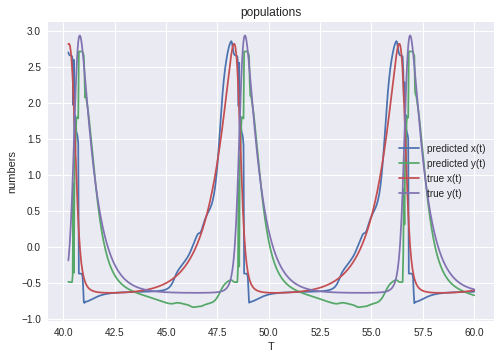

In [0]:
test = Evaluation(model)
test.plot()
print('L2 error is [x,y] = ' + np.array2string(test.l2_error()))

array([40.24      , 40.2700304 , 40.30006079, 40.33009119, 40.36012158,
       40.39015198, 40.42018237, 40.45021277, 40.48024316, 40.51027356,
       40.54030395, 40.57033435, 40.60036474, 40.63039514, 40.66042553,
       40.69045593, 40.72048632, 40.75051672, 40.78054711, 40.81057751,
       40.8406079 , 40.8706383 , 40.90066869, 40.93069909, 40.96072948,
       40.99075988, 41.02079027, 41.05082067, 41.08085106, 41.11088146,
       41.14091185, 41.17094225, 41.20097264, 41.23100304, 41.26103343,
       41.29106383, 41.32109422, 41.35112462, 41.38115502, 41.41118541,
       41.44121581, 41.4712462 , 41.5012766 , 41.53130699, 41.56133739,
       41.59136778, 41.62139818, 41.65142857, 41.68145897, 41.71148936,
       41.74151976, 41.77155015, 41.80158055, 41.83161094, 41.86164134,
       41.89167173, 41.92170213, 41.95173252, 41.98176292, 42.01179331,
       42.04182371, 42.0718541 , 42.1018845 , 42.13191489, 42.16194529,
       42.19197568, 42.22200608, 42.25203647, 42.28206687, 42.31